In [1]:
using Agents
# using InteractiveDynamics
using GLMakie
using Plots
using Random
using Distributions
using Statistics
using StatsBase
using DataFrames, DataFramesMeta


In [2]:
function GiniCoefficientJulia(x)
    n = length(x)
    shift = abs(minimum(x, init=0))
    x = x .+ shift
    # If all values are zero, return 0
    if sum(x) == 0
        return 0
    end
    
    # Sort the values
    x = sort(x)
    
    # Calculate the rank of each value
    rank = collect(1:n)
    
    # Calculate the Gini coefficient using the formula
    return (1 / n) * (2 * sum(rank .* x) / sum(x) - (n + 1))
end


GiniCoefficientJulia (generic function with 1 method)

In [3]:
@agent SchellingAgent GridAgent{2} begin
    remain::Bool 
    group::Int
    money::Float64
    injection_agent::Bool
    money_change::Float64
    pos_neg_neutral_change::Int64
    distance_from_injection::Float64
    k1::Float64
    k2::Float64

    potential_energy::Int
    kinetic_energy::Float64 
    
end

In [4]:
agent_money_gain = 10_000_000 
MOVEMENT_ENERGY_MIN_REQUIREMENT = 0.01

0.01

In [5]:
seed = 123;

#golden agent money gain

const NN = 13;
const GRID_DIM = (NN,NN);
TOTAL_AGENTS = round( Int, 0.80*prod(GRID_DIM) );

# AGENTS_MONEY = rand(MONEY_DISTRIBUTION, TOTAL_AGENTS)
MAX_MONEY = maximum( agent_money_gain );




KineticEnergy(money) = 2 * money / MAX_MONEY
InvKineticEnergy(kinetic_energy) = (1/2) * MAX_MONEY * kinetic_energy #returns the money and money is then effectively the energy
PotentialEnergy(remain) = 1 * Int( !remain )
FIXED_ENERGY_BINS = 0:0.2:1_000;

In [6]:
scheduler_model = Schedulers.Randomly();

function initialize(; min_to_be_happy_corner = 2,
    min_to_be_happy_inner = 4, 
    min_to_be_happy_side = 3,
    corner_surround = 3,
    inner_surround = 8, 
    side_surround = 5,
    max_distance_from_injection = 0.0, #added a model property to plot the total distance from injection 
    model_entropy_prev = 0.0,
    model_entropy = 0.0,
    GRID_DIM = GRID_DIM)

    global model_iteration = 0

    space = GridSpaceSingle(GRID_DIM, periodic = false)

    params = Dict(
    :min_to_be_happy_inner => min_to_be_happy_inner, 
    :min_to_be_happy_side => min_to_be_happy_side, 
    :min_to_be_happy_corner => min_to_be_happy_corner,
    :inner_surround => inner_surround, 
    :side_surround => side_surround, 
    :corner_surround => corner_surround,
    :max_distance_from_injection => max_distance_from_injection,
    :model_entropy_prev => model_entropy_prev,
    :model_entropy => model_entropy,
    # :MOVEMENT_ENERGY_MIN_REQUIREMENT => MOVEMENT_ENERGY_MIN_REQUIREMENT
    )

    properties = params

    rng = Random.Xoshiro(seed)

    model = UnremovableABM(SchellingAgent, space; rng=rng, properties=properties, 
                            scheduler=scheduler_model)

    for ii in 1:TOTAL_AGENTS
        remain_i = false
        identity_i = ii < TOTAL_AGENTS/2 ? 1 : 2
        money_i = 0
        injection_agent = false
        money_change = 0
        pos_neg_neutral_change = 0
        distance_from_injection = 0
        k1 = 0 
        k2 = 0
        
        potential_energy_i = PotentialEnergy(remain_i)
        kinetic_energy_i = KineticEnergy(money_i)


        agent = SchellingAgent(ii, (1, 1), remain_i, identity_i, money_i,
                                    injection_agent, money_change, pos_neg_neutral_change, distance_from_injection,
                                    k1, k2, potential_energy_i, kinetic_energy_i)
        add_agent_single!(agent, model)
    end
    return model
end

initialize (generic function with 1 method)

In [7]:
function GetAgentRemainStatus(agent, model, count_near, count_neighbors_same_group)
    
    #agent moves it remain is false and kinetic is higher than potential
    kinetic_higher_than_potential = agent.kinetic_energy > MOVEMENT_ENERGY_MIN_REQUIREMENT #PotentialEnergy(agent.remain)
    
    remain = true

    if count_near == model.inner_surround && count_neighbors_same_group >= model.min_to_be_happy_inner
        remain = true
    elseif count_near == model.side_surround && count_neighbors_same_group >= model.min_to_be_happy_side
        remain = true
    elseif count_near == model.corner_surround && count_neighbors_same_group >= model.min_to_be_happy_corner
        remain = true
    else
        remain = false
    end
    
    if( kinetic_higher_than_potential == true && remain == false )
        return false
    else
        return true
    end    
    
end

GetAgentRemainStatus (generic function with 1 method)

In [8]:
function MovementMoneySpending(agent, model)
    
    money_spent = InvKineticEnergy(MOVEMENT_ENERGY_MIN_REQUIREMENT)
    
    if( money_spent >= agent.money )
        return
    else
        agent.money -=  money_spent
    end
    
    
    agent.kinetic_energy = KineticEnergy(agent.money)
    
    number_of_neighbors = length( collect( nearby_agents( agent, model ) ) )
    neighbor_dividend = money_spent / number_of_neighbors
    # modify to have only 1 agent receive all the quanta of money
    for neighbor in nearby_agents( agent, model )
        neighbor.money += neighbor_dividend
        neighbor.kinetic_energy = KineticEnergy(neighbor.money)
    end
    
end

MovementMoneySpending (generic function with 1 method)

In [9]:
function MoneySpending(agent, model)
    money_spent = agent.money * 0.05
    
    agent.money -=  money_spent
    
    agent.kinetic_energy = KineticEnergy(agent.money)
    
end

MoneySpending (generic function with 1 method)

In [46]:
function agent_step!(agent, model)

    agent_golden = model[1]
    #added a chosen one that gets the glorious lump sum of cash injection which chooses it by the id=1

    if agent.injection_agent == true
        agent.injection_agent = true
    end

    if agent.money > 1_000_000
        agent.injection_agent = true
    end



    agent.k1 = agent.kinetic_energy

    agent.money_change = InvKineticEnergy(agent.k1 - agent.k2)

    if agent.money_change != 0
        agent.distance_from_injection = euclidean_distance(agent.pos, agent_golden.pos, model)
    end

    if agent.money_change > 0 
        agent.pos_neg_neutral_change = 1
    end
            


    #changes the Bool for the golden agent to true

    count_near = 0
    for pos in nearby_positions( agent.pos , model )
        count_near += 1
    end
    
    count_neighbors_same_group = 0    

    for neighbor in nearby_agents( agent, model )
        if agent.group == neighbor.group
            count_neighbors_same_group += 1
        end
    end

    agent.remain = GetAgentRemainStatus(agent, model, count_near, count_neighbors_same_group) 
    agent.potential_energy = PotentialEnergy( agent.remain )
    
    if agent.remain == false
        randomwalk!(agent, model, 1)
        #walks the agent within his immediate neighbors (3 by 3)
        #if using r=2 this will include a (5 by 5)
        MovementMoneySpending(agent, model)
    end

    MoneySpending(agent, model)


    agent.k2 = agent.kinetic_energy

    if agent.money_change == 0
        agent.money_change = InvKineticEnergy(agent.k2 - agent.k1)

        if agent.money_change != 0
            agent.distance_from_injection = euclidean_distance(agent.pos, agent_golden.pos, model)
        end

        if agent.money_change < 0 
            agent.pos_neg_neutral_change = -1
        end
    end
        
end  

agent_step! (generic function with 1 method)

In [11]:
function ModelRemainTrajectory(model)
    remain = 0
    for agent in allagents(model)
        remain += agent.remain 
    end
    return remain / nagents(model)
end

ModelRemainTrajectory (generic function with 1 method)

In [12]:
function ModelFinancialDisparity(model)
    disparity = 0
    for agent in allagents(model)
        
        disparity_temp = 0
        number_of_neighbors = length( collect( nearby_agents(agent, model, 1) ) )
        
        for neighbor in nearby_agents(agent, model, 1)
            disparity_temp += abs( agent.money - neighbor.money )
        end
        
        if( number_of_neighbors > 0 )
            disparity_temp = disparity_temp / number_of_neighbors
            disparity += disparity_temp
        end

    end
    return disparity
end

ModelFinancialDisparity (generic function with 1 method)

In [66]:
function ModelEntropy(model)
    
    agent_energies = Float64[]

    model.model_entropy_prev = model.model_entropy
    
    for agent in allagents(model)
        agent_energy = agent.kinetic_energy + agent.potential_energy 
        push!(agent_energies, agent_energy)
    end
    energy_hist = fit(Histogram, agent_energies, FIXED_ENERGY_BINS)
    energy_weights = energy_hist.weights
    nonzero_weights = filter(!iszero, energy_weights)
    energy_probabilities = nonzero_weights ./ sum(nonzero_weights)

    SS = 0
    for ii in 1:length( energy_probabilities )
        SS += (-1) * energy_probabilities[ii] * log( energy_probabilities[ii] )
    end

    model.model_entropy = SS
    
    return SS
end

ModelEntropy (generic function with 1 method)

In [14]:
function ModelInternalEnergy(model)
    # U = sum_distinct_states_i p_i * E_i
    
    agent_energies = Float64[]
    
    for agent in allagents(model)
        agent_energy = agent.kinetic_energy + agent.potential_energy
        push!(agent_energies, agent_energy)

    end
    
    energy_hist = fit(Histogram, agent_energies, FIXED_ENERGY_BINS)
    energy_probabilities = energy_hist.weights ./ sum(energy_hist.weights)
    energy_edges = collect( energy_hist.edges[1] )
    energy_values = [ (energy_edges[i]+energy_edges[i+1])/2 for i in 1:length(energy_edges)-1 ]
    
    UU = 0
    for ii in 1:length(energy_values)
        UU += energy_probabilities[ii] * energy_values[ii]
    end
    
    return UU
end

ModelInternalEnergy (generic function with 1 method)

In [15]:
function ModelInjectionDistance(model)

    max_distance = 0.0

    for agent in allagents(model)

        max_distance = maximum(agent.distance_from_injection)

        if model.max_distance_from_injection < max_distance
            model.max_distance_from_injection = max_distance
        end

    end
    
end

ModelInjectionDistance (generic function with 1 method)

In [114]:
model_iteration = 0;

function model_step!(model)

    global model_iteration += 1

    agent_golden = model[1]

    if model_iteration == 5
        agent_golden.money += agent_money_gain
        agent_golden.kinetic_energy = KineticEnergy(agent_golden.money)       
    end

    if model_iteration == 15
        if (model.model_entropy - model.model_entropy_prev < 0)
            agent_golden2 = model[20]        
            agent_golden2.money += agent_money_gain
            agent_golden2.kinetic_energy = KineticEnergy(agent_golden.money)       
        end
    end

end

model_step! (generic function with 1 method)

In [20]:
model

UnremovableABM with 135 agents of type SchellingAgent
 space: GridSpaceSingle with size (13, 13), metric=chebyshev, periodic=false
 scheduler: Agents.Schedulers.Randomly
 properties: max_distance_from_injection, corner_surround, min_to_be_happy_side, side_surround, model_entropy_prev, inner_surround, min_to_be_happy_inner, model_entropy, min_to_be_happy_corner

In [18]:
#=
My idea here is to have a model step that will look at the (entropy?) and determine if it is increasing, staying constant, or decreasing
If it is decreasing then it will pick a random agent on the grid and inject it with money
The issue is that if the agents become happy then the system will keep injecting therefore there has to be some sort of relocating for the sake of it (Garibay's paper)
This random moving after attaining satisfaction can be quantized to its lowest level in order to keep the system going (control variable)
The measured variable is the entropy of the system
Dependent variable: entropy Independent variable: money injection, random moving
=#



#=
Currently the problem is to get the current steps entropy to compare to the previous entropy step
=#

In [110]:
adata = [ :potential_energy, :kinetic_energy, :distance_from_injection, :money, :money_change, :injection_agent, :k1, :k2, :pos, :pos_neg_neutral_change]
mdata = [ ModelRemainTrajectory, ModelFinancialDisparity, 
                        ModelEntropy, ModelInternalEnergy, ModelInjectionDistance, :max_distance_from_injection, :model_entropy_prev, :model_entropy]



model = initialize()

step_num = 200;
agent_df, model_df = run!(model, agent_step!, model_step!, step_num; adata , mdata)

(27135×12 DataFrame
   Row │ step   id     potential_energy  kinetic_energy  distance_from_injecti ⋯
       │ Int64  Int64  Int64             Float64         Float64               ⋯
───────┼────────────────────────────────────────────────────────────────────────
     1 │     0      1                 1      0.0                         0.0   ⋯
     2 │     0      2                 1      0.0                         0.0
     3 │     0      3                 1      0.0                         0.0
     4 │     0      4                 1      0.0                         0.0
     5 │     0      5                 1      0.0                         0.0   ⋯
     6 │     0      6                 1      0.0                         0.0
     7 │     0      7                 1      0.0                         0.0
     8 │     0      8                 1      0.0                         0.0
   ⋮   │   ⋮      ⋮           ⋮                ⋮                    ⋮          ⋱
 27129 │   200    129           

In [95]:
using CSV

CSV.write("C:\\Users\\tyler\\OneDrive\\Desktop\\outputall.csv", agent_df)

"C:\\Users\\tyler\\OneDrive\\Desktop\\outputall.csv"

In [94]:
using CSV

CSV.write("C:\\Users\\tyler\\OneDrive\\Desktop\\output.csv", transform=(col, val) -> something(val,missing), model_df)

"C:\\Users\\tyler\\OneDrive\\Desktop\\output.csv"

In [ ]:
count_true_rows = sum(agent_df[!, :pos_neg_neutral_change] .== -1)

println("Number of true rows: $count_true_rows")

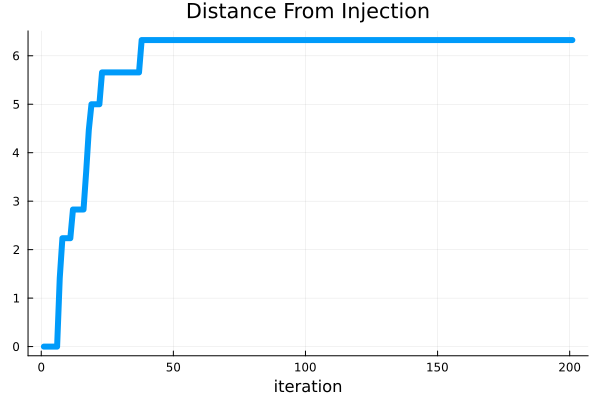

In [111]:
plot_distance = Plots.plot( model_df[!,:max_distance_from_injection], linewidth=6, legend=false,
            title="Distance From Injection", xlabel="iteration" )

In [ ]:
# savefig(plot_distance,"./Plots/Iteration11.pdf")

In [ ]:
line_df = subset(model_df, :step => ByRow(≥(5)));
line_df[:, [:step, :max_distance_from_injection]];
line_df2 = subset(line_df, :step => ByRow(≤(40)));
line_df2

In [ ]:
x_variable = collect(0:(length(line_df2[!, :max_distance_from_injection])-1));

In [ ]:
using Polynomials

In [ ]:
# x_variable = len(line_df3[:, :max_distance_from_injection])
x_variable = x_variable
y = line_df2[:, :max_distance_from_injection]
quadfit = Polynomials.fit(x_variable,y,1)

In [ ]:
x = 0:1:(length(line_df2[!, :max_distance_from_injection]))

y_equation(x) = 1.1156918869822177  +  0.17225148792029915.*x
plot_equation = Plots.plot(x, y_equation, linewidth=6, legend=false,
        title="Rate of Injection", xlabel="iteration")
plot_line = Plots.plot!(line_df2[:, :max_distance_from_injection], linewidth=6, legend=false,
            title="Distance From Injection", xlabel="iteration")

In [ ]:
rate_of_change = [
    0.12062744751116745, 0.1906600589429725, 0.2995332774113677, 0.10017951952831972, 0.1803274709938228, 0.09787191118284916, 0.24337276050137302, 0.120465407192974, 0.25885858741784173, 0.3143835242964018,
    0.21517217737097122, 0.21517217737097122, 0.14516513041375442, 0.11152327236089055, 0.2614331598089488, 0.20832628899791317, 0.1977734622714515, 0.19362606723616957, 0.1902635545995243, 0.17864957416356858,
    0.15399009862389504, 0.185437120473138, 0.29637636031459846, 0.32371926830683323, 0.2273697124161938, 0.14115661777724203, 0.14729176439187325, 0.11587399199360944, 0.17225148792029915, 0.15450293448249117
];

In [ ]:
ROC_average = mean(rate_of_change);
ROC_std = std(rate_of_change);

println("The average rate of change for the first injection (of each simulation) per 20 simulations is: $ROC_average

The standard deviation of the first injection (of each simulation) for 20 simulations is: $ROC_std
")

In [ ]:
ROC_distribution = Plots.histogram( rate_of_change, bins=0:0.05:0.5, title="ROC Distribution" )

ROC_distribution
# savefig(ROC_distribution,"./Plots/ROC_distribution_ripples.pdf")

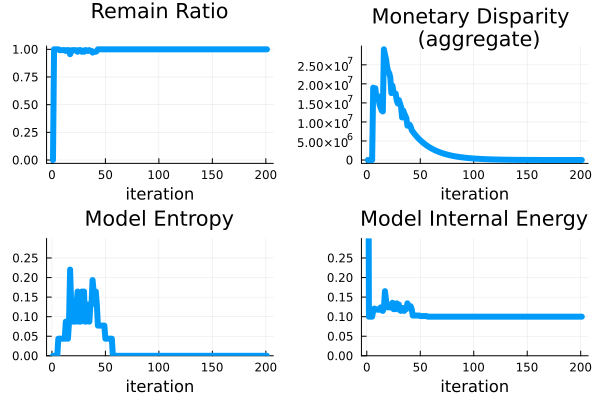

In [112]:
p1 = Plots.plot( model_df[!,:ModelRemainTrajectory], linewidth=6, legend=false, 
title="Remain Ratio", xlabel="iteration" )
p2 = Plots.plot( model_df[!,:ModelFinancialDisparity], linewidth=6, legend=false,
            title="Monetary Disparity \n (aggregate)", xlabel="iteration" )
p3 = Plots.plot( model_df[!,:ModelEntropy], linewidth=6, legend=false,
            title="Model Entropy", xlabel="iteration", ylim=[0,0.3])
p4 = Plots.plot( model_df[!,:ModelInternalEnergy], linewidth=6, legend=false,
            title="Model Internal Energy", xlabel="iteration", ylim=[0,0.3])

pOveral = Plots.plot([p1,p2,p3,p4]..., layout=grid(2,2) )

In [101]:
gini_internal_U = []
gini_kinetic = []
percentage_remain = []
kinetic_means = []

Any[]

In [102]:
for step in 1:step_num
    agent_U_vals = agent_df[isequal.(agent_df.step, step), :][!,:potential_energy]
    gini = GiniCoefficientJulia( agent_U_vals )
    push!(gini_internal_U,gini)
    push!(percentage_remain, length( findall( agent_U_vals .== 0 ) ) / TOTAL_AGENTS )
    
    agent_K_vals = agent_df[isequal.(agent_df.step, step), :][!,:kinetic_energy]
    agent_K_groups = (KineticEnergy(MAX_MONEY)/100) .* div.(agent_K_vals, KineticEnergy(MAX_MONEY)/100 ) 
    
    if( length(findall( agent_K_vals .< 0 )) > 0 )
        println("BAD")
        println(agent_K_vals)
    end
    gini = GiniCoefficientJulia( agent_K_groups )
    push!(gini_kinetic,gini)
    push!(kinetic_means, mean(agent_K_vals))
end

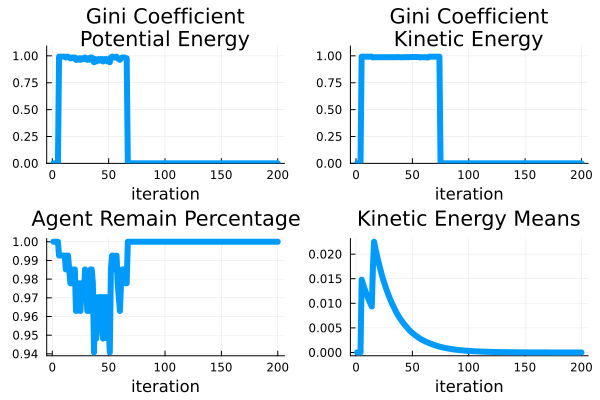

In [103]:
p1_gini = Plots.plot(gini_internal_U, linewidth=6, legend=false,
            title="Gini Coefficient\nPotential Energy", xlabel="iteration",
            ylim=ylim=[0,maximum(gini_internal_U)*1.1])
p2_gini = Plots.plot(gini_kinetic, linewidth=6, legend=false,
                title="Gini Coefficient\nKinetic Energy", xlabel="iteration",
                ylim=[0,maximum(gini_kinetic)*1.1])
p3_gini = Plots.plot(percentage_remain, linewidth=6, legend=false,
                title="Agent Remain Percentage", xlabel="iteration" )
p4_gini = Plots.plot(kinetic_means, linewidth=6, legend=false,
                title="Kinetic Energy Means", xlabel="iteration" )
p_gini = Plots.plot([p1_gini,p2_gini,p3_gini,p4_gini]...,layout=grid(2,2))

In [40]:
using Colors
using ColorSchemes

In [41]:
function number_to_thermal_color(n::Float64)
    color_scheme = ColorSchemes.Pastel1_3
    rangescale =(-1000, 1000)
    # color_scheme = ColorScheme([RGB{Float64}(i, i, i) for i in -41_000:20_000:333_333])
    # Use the number to get a color from the scheme
    color = get(color_scheme, n, rangescale)    
    return color
end

number_to_thermal_color (generic function with 1 method)

In [42]:
function FinanceColor(agent) 
    money_change = agent.money_change
    return number_to_thermal_color(money_change)
end

FinanceColor (generic function with 1 method)

In [91]:
groupcolor(a) = a.money_change
groupmarker(a) = a.injection_agent == true ? :circle : :rect
groupsize(a) = a.pos_neg_neutral_change 

groupsize (generic function with 1 method)

In [44]:
GLMakie.activate!(inline=false)

In [104]:
injection_map, _ = Agents.abmplot( model ; ac = FinanceColor, am = groupmarker, as = 25,
                            axis = (; title = "Injection Map", titlesize=20, xticks=(0:2:14), yticks=(0:2:14)))
injection_map



In [105]:
model = initialize()

fig, _ = Agents.abmexploration(model; 
                agent_step!,
                model_step!,
                ac=FinanceColor, am=groupmarker, as = 35,
                figure=(;resolution=(600,600))
                )
display(fig)

GLMakie.Screen(...)

In [113]:
model = initialize()

set_theme!()

fig, _ = Agents.abmvideo("pos_neg_injection_ripple_test.mp4", model, 
                agent_step!,
                model_step!;
                ac=FinanceColor, am=groupmarker, as = 25,
                framerate = 1,
                frames = 75,
                title="Speed of Sound Ripple",
                )


MethodError: MethodError: no method matching iterate(::Nothing)

Closest candidates are:
  iterate(!Matched::Union{LinRange, StepRangeLen})
   @ Base range.jl:880
  iterate(!Matched::Union{LinRange, StepRangeLen}, !Matched::Integer)
   @ Base range.jl:880
  iterate(!Matched::T) where T<:Union{Base.KeySet{<:Any, <:Dict}, Base.ValueIterator{<:Dict}}
   @ Base dict.jl:698
  ...
